In [2]:
import h5py as h5
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import seaborn as sns
import legwork

import sys
sys.path.append("../src/")
from variations import variations
from galaxy import simulate_mw

In [3]:
%config InlineBackend.figure_format = 'retina'
plt.rc('font', family='serif')
fs = 20

params = {'legend.fontsize': fs,
         'axes.labelsize': fs,
         'xtick.labelsize':0.7*fs,
         'ytick.labelsize':0.7*fs}
plt.rcParams.update(params)

In [4]:
dco_colours = {"BHBH": plt.get_cmap("plasma")(0.2), 
               "BHNS": plt.get_cmap("plasma")(0.5),
               "NSNS": plt.get_cmap("plasma")(0.8)}

dco_types = ["BHBH", "BHNS", "NSNS"]
sim_folder = "../data/simulation_plus_channels/"

total_DCOs_in_MW = np.load("../data/total_DCO_in_MW.npy")
total_bound_DCOs_in_MW = np.load("../data/total_DCO_in_MW_nohubble.npy")

detections = np.load("../data/detections_4yr.npy")
detections_10yr = np.load("../data/detections_10yr.npy")

# Fiducial Simulation Analysis

## Detectable Harmonics

In [5]:
def number_of_detectable_harmonics(m_c, dist, f_orb, ecc, snr_cutoff=7, t_obs=4 * u.yr, nmax=50):
    
    # calculate the strain for each of the n harmonics and convert to signal over LISA mission
    n_range = np.arange(1, nmax).astype(int)
    hn = legwork.strain.h_0_n(m_c=m_c, dist=dist, f_orb=f_orb, n=n_range, ecc=ecc)
    signal_n_squared = t_obs * hn[:,0,:]**2

    # find the square of the noise at each of the harmonic frequency for a mission of length t_obs
    noise_n_squared = legwork.psd.lisa_psd(f=f_orb[:, np.newaxis] * n_range, t_obs=t_obs)

    # calculate the SNR as the ratio of these quantities
    snr_n_squared = (signal_n_squared / noise_n_squared).decompose()
    
    return (snr_n_squared > snr_cutoff).astype(int).sum(axis=1)

0
1
2


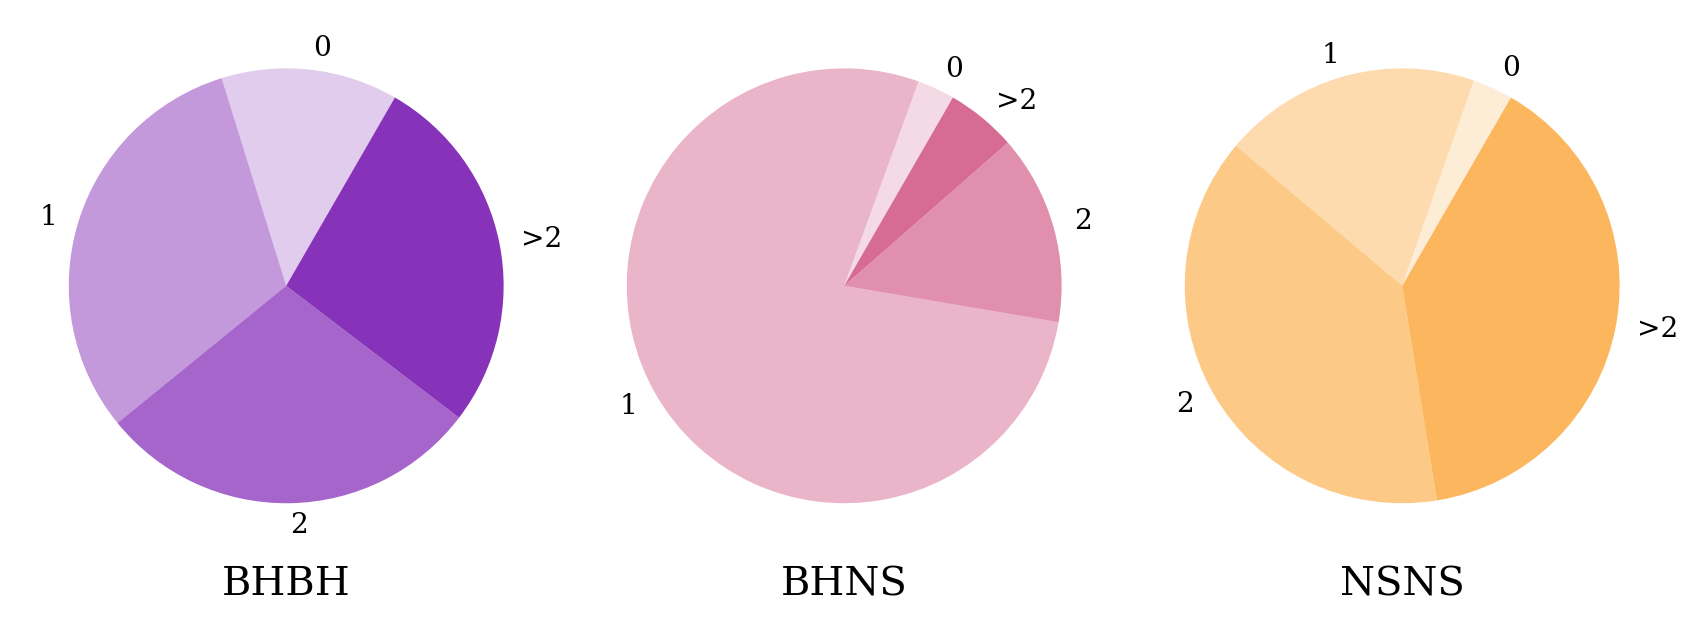

In [116]:
nharm = {"BHBH": None, "BHNS": None, "NSNS": None}

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

fig.subplots_adjust(wspace=0.0)

t_obs = 10 * u.yr

for i in range(len(dco_types)):
    with h5.File(sim_folder + "{}_fiducial_all.h5".format(dco_types[i]), "r") as f:
        full_data = f["simulation"][...].squeeze()
        snr_mask = full_data["snr"] * np.sqrt(t_obs / (4 * u.yr)) > 7
        data = full_data[snr_mask]
        
    m_c = legwork.utils.chirp_mass(data["m_1"], data["m_2"]) * u.Msun
    f_orb_LISA = legwork.utils.get_f_orb_from_a(data["a_LISA"] * u.AU,
                                                data["m_1"] * u.Msun, data["m_2"] * u.Msun)
    
    nharm[dco_types[i]] = number_of_detectable_harmonics(m_c, data["dist"] * u.kpc, f_orb_LISA, data["e_LISA"], snr_cutoff=2)
    harmonics, counts = np.unique(nharm[dco_types[i]], return_counts=True)
    sizes = [counts[0], counts[1], counts[2], counts[3:].sum()]
    labels = ["0", "1", "2", ">2"]
    colors = [dco_colours[dco_types[i]][0:3] + (0.2 * j,) for j in range(1, len(labels) + 1)]
    ax[i].pie(sizes, labels=labels, startangle=60, colors=colors)
    ax[i].set_xlabel(dco_types[i])
    print(i)

plt.show()

0
1
2


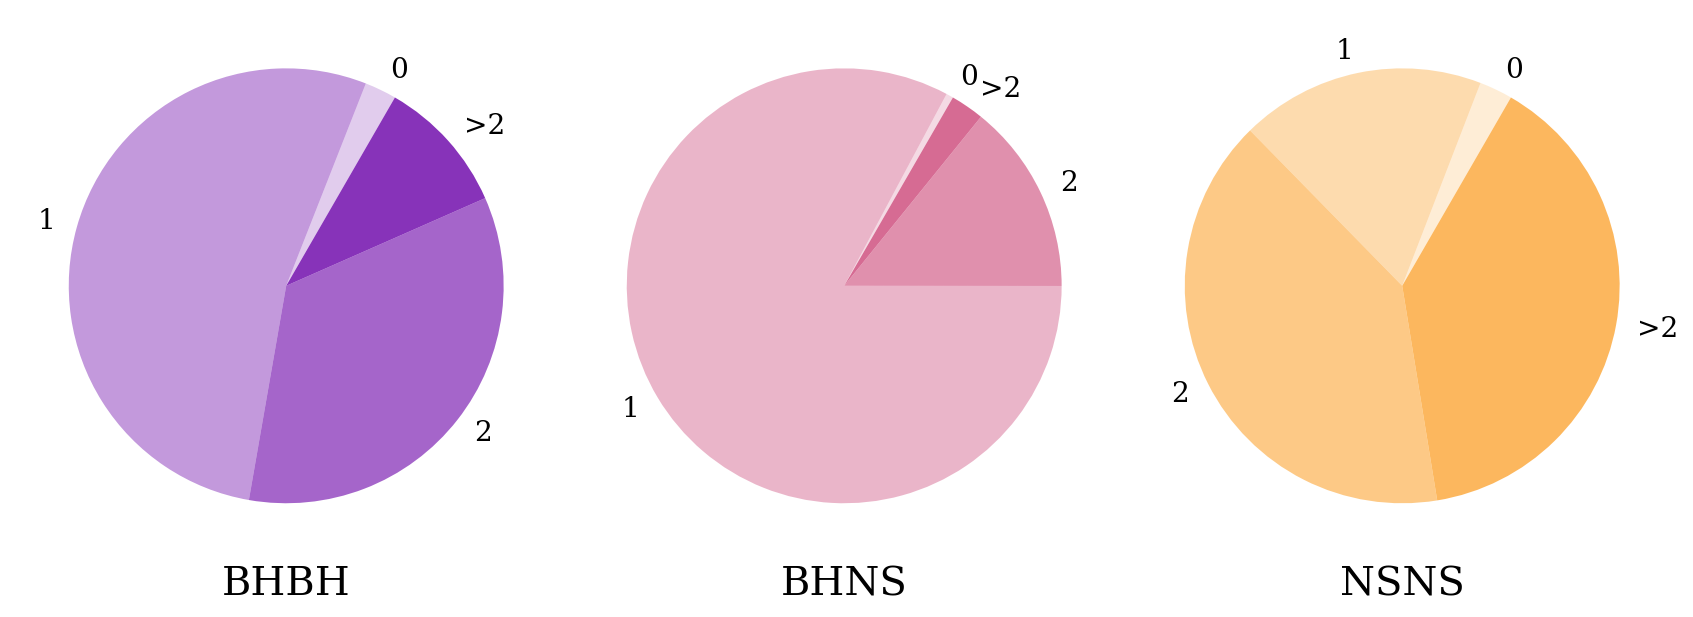

In [133]:
nharm_unique = {"BHBH": None, "BHNS": None, "NSNS": None}

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

fig.subplots_adjust(wspace=0.0)

t_obs = 10 * u.yr

for i in range(len(dco_types)):
    with h5.File(sim_folder + "{}_fiducial_all.h5".format(dco_types[i]), "r") as f:
        full_data = f["simulation"][...].squeeze()
        snr_mask = full_data["snr"] * np.sqrt(t_obs / (4 * u.yr)) > 7
        data = full_data[snr_mask]
        
        _, places = np.unique(data["seed"], return_index=True)
        data = data[places]
        
    m_c = legwork.utils.chirp_mass(data["m_1"], data["m_2"]) * u.Msun
    f_orb_LISA = legwork.utils.get_f_orb_from_a(data["a_LISA"] * u.AU,
                                                data["m_1"] * u.Msun, data["m_2"] * u.Msun)
    
    nharm_unique[dco_types[i]] = number_of_detectable_harmonics(m_c, data["dist"] * u.kpc, f_orb_LISA, data["e_LISA"], snr_cutoff=2)
    harmonics, counts = np.unique(nharm_unique[dco_types[i]], return_counts=True)
    sizes = [counts[0], counts[1], counts[2], counts[3:].sum()]
    labels = ["0", "1", "2", ">2"]
    colors = [dco_colours[dco_types[i]][0:3] + (0.2 * j,) for j in range(1, len(labels) + 1)]
    ax[i].pie(sizes, labels=labels, startangle=60, colors=colors)
    ax[i].set_xlabel(dco_types[i])
    print(i)

plt.show()

## Parameter distributions

In [8]:
def sky_localisation(snr, fGW, L=2*u.AU):
    sigma_theta = 16.6 * (7 / snr) * (5e-4 * u.Hz / fGW) * (2 * u.AU / L) * u.deg
    return sigma_theta.to(u.deg)

def f_uncertainty(snr, t_obs, f):
    return (4 * np.sqrt(3) / np.pi / (snr * t_obs) / f).decompose()

def fdot_uncertainty(snr, t_obs, fdot):
    return (6 * np.sqrt(5) / np.pi / (snr * t_obs**2) / fdot).decompose()

def Fprime_over_F(e):
    return e * (1256 + 1608 * e**2 + 111 * e**4) / (96 + 196 * e**2 - 255 * e**4 - 37 * e**6)

In [147]:
def grid_plot(model=0, t_obs=10 * u.yr, unique=False):
    fig, axes = plt.subplots(3, 3, figsize=(22, 15))

    plt.subplots_adjust(top=0.94)

    lw = 4

    for dco_type in ["BHBH", "BHNS", "NSNS"]:
        with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[model]["file"]), "r") as f:
            full_data = f["simulation"][...].squeeze()
            snr_mask = full_data["snr"] * (t_obs / (4 * u.yr))**(0.5) > 7

            data = full_data[snr_mask]
            if unique:
                _, places = np.unique(data["seed"], return_index=True)
                data = data[places]

        m_c = legwork.utils.chirp_mass(data["m_1"], data["m_2"]) * u.Msun
        f_orb_LISA = legwork.utils.get_f_orb_from_a(m_1=data["m_1"] * u.Msun, m_2=data["m_2"] * u.Msun,
                                              a=data["a_LISA"] * u.AU)
        f_dot = legwork.utils.fn_dot(m_c=m_c, f_orb=f_orb_LISA, e=data["e_LISA"], n=1)
        sigma_theta = sky_localisation(data["snr"], f_orb_LISA * 2).to(u.deg)
        
        t_merge = legwork.evol.get_t_merge_ecc(ecc_i=data["e_DCO"], a_i=data["a_DCO"] * u.AU,
                                          m_1=data["m_1"] * u.Msun, m_2=data["m_2"] * u.Msun).to(u.Gyr)

        D_fdot = fdot_uncertainty(data["snr"] , t_obs, f_dot)
        D_f = f_uncertainty(data["snr"], t_obs, f_orb_LISA)
        
        if unique:
            D_e = np.where(nharm_unique[dco_type] > 1, 0.05, np.where(nharm_unique[dco_type] == 0, 1, 0.1))
        else:
            D_e = np.where(nharm[dco_type] > 1, 0.05, np.where(nharm[dco_type] == 0, 1, 0.1))
        D_Mc = 11 / 5 * D_f + 3 / 5 * D_fdot + 3 / 5 * Fprime_over_F(data["e_LISA"]) * D_e

        localised = sigma_theta <= np.sqrt(0.67 / np.pi) * u.deg
        distinguished = D_Mc <= 0.1
        print(variations[model]["med"])
        print(dco_type, len(data["m_1"]))
        print("\tDetections {:1.2f}".format(detections_10yr[dco_types.index(dco_type)][model].mean()))
        print("\tLocalised detections {:1.2f}".format(detections_10yr[dco_types.index(dco_type)][model].mean()
                                                      * len(data[localised]) / len(data)))
        print("\tDistinguished detections {:1.2f}".format(detections_10yr[dco_types.index(dco_type)][model].mean()
                                                          * len(data[distinguished]) / len(data)))
        print("\tLocalised AND distinguished detections {:1.2f}".format(detections_10yr[dco_types.index(dco_type)][model].mean()
                                                                        * len(data[np.logical_and(localised, distinguished)]) / len(data)))

        if dco_type == "BHNS":
            mBH = np.maximum(data["m_1"], data["m_2"])
            mNS = np.minimum(data["m_1"], data["m_2"])
            mass_weights = data["weight"]
        elif dco_type == "BHBH":
            mBH = np.concatenate((data["m_1"], data["m_2"]))
            mass_weights = np.concatenate((data["weight"], data["weight"]))
        elif dco_type == "NSNS":
            mNS = np.concatenate((data["m_1"], data["m_2"]))
            mass_weights = np.concatenate((data["weight"], data["weight"]))
            
        if dco_type in ["BHNS", "BHBH"]:
            sns.kdeplot(mBH, weights=mass_weights, ax=axes[0, 0], bw_adjust=1.0, color=dco_colours[dco_type], lw=lw, label=dco_type)
            axes[0, 0].set_xlabel(r"Black Hole Mass, $m_{\rm BH} \, [\rm M_{\odot}]$")
            axes[0, 0].set_xlim(2, 20)

        if dco_type in ["BHNS", "NSNS"]:
            sns.kdeplot(mNS, weights=mass_weights, ax=axes[0, 1], bw_adjust=0.8, color=dco_colours[dco_type], cut=0, lw=lw, label=dco_type)
            axes[0, 1].set_xlabel(r"Neutron Star Mass, $m_{\rm NS} \, [\rm M_{\odot}]$")
            axes[0, 1].set_xlim(1.26, 2.5)
            
        sns.kdeplot(np.log10(f_orb_LISA.value), weights=data["weight"], ax=axes[0, 2], bw_adjust=1, color=dco_colours[dco_type], cut=0, lw=lw, label=dco_type)
        axes[0, 2].set_xlabel(r"Orbital Frequency, $\log_{10}(f_{\rm orb, LISA} / {\rm Hz})$")
        axes[0, 2].set_xlim(-5.9, -1.8)

        sns.kdeplot(data["dist"], weights=data["weight"], ax=axes[1, 0], bw_adjust=1, color=dco_colours[dco_type], cut=0, lw=lw, label=dco_type)
        axes[1, 0].set_xlabel(r"Luminosity Distance, $D_{\rm L} \, [\rm kpc]$")
        axes[1, 0].set_xlim(0, 25)
        axes[1, 0].axvline(8.2, color="grey", linestyle="dotted", zorder=0)
        axes[1, 0].annotate("Milky Way Centre", xy=(8.2, 0.05), color="grey", rotation=90, ha="center", va="center",
                            bbox=dict(boxstyle="round", ec="white", fc="white"), fontsize=0.55*fs)
        
        sns.kdeplot(data["tau"], weights=data["weight"], ax=axes[1, 1], bw_adjust=1, color=dco_colours[dco_type], lw=lw, label=dco_type, cut=0)
        axes[1, 1].set_xlabel(r"Lookback Time, $\tau \, [\rm Gyr]$")
        axes[1, 1].set_xlim(0, 12)
        
#         sns.kdeplot(np.log10(data["Z"]), weights=data["weight"], ax=axes[1, 2], cut=0, bw_adjust=1.5, color=dco_colours[dco_type], lw=lw, label=dco_type)

        sns.ecdfplot(x=np.log10(D_Mc.value), weights=data["weight"] / np.sum(data["weight"]) * detections[dco_types.index(dco_type)][model].mean(),
                     ax=axes[2, 0], color=dco_colours[dco_type], lw=lw, label=dco_type, stat="count")
        axes[2, 0].set_xlabel(r"Chirp Mass Error, $\log_{10}(\Delta \mathcal{M}_c / \mathcal{M}_c)$")
        axes[2, 0].set_xlim(-4.1, 2.5)
        axes[2, 0].axvspan(0, axes[2, 0].get_xlim()[1], color="grey", zorder=10, alpha=0.2)

        sns.ecdfplot(x=np.log10(data["e_LISA"]), weights=data["weight"] / np.sum(data["weight"]) * detections[dco_types.index(dco_type)][model].mean(),
                     ax=axes[2, 1], color=dco_colours[dco_type], lw=lw, label=dco_type, stat="count")
        axes[2, 1].set_xlabel(r"Eccentricity, $\log_{10}(e_{\rm LISA})$")
        axes[2, 1].set_xlim(-3.9, 0)
        axes[2, 1].axvspan(axes[2, 1].get_xlim()[0], -2, color="grey", zorder=10, alpha=0.2)
        
        sns.ecdfplot(x=np.log10(sigma_theta.value), weights=data["weight"] / np.sum(data["weight"]) * detections[dco_types.index(dco_type)][model].mean(),
                     ax=axes[2, 2], color=dco_colours[dco_type], lw=lw, label=dco_type, stat="count")
        axes[2, 2].set_xlabel(r"Angular Resolution, $\log_{10}(\sigma_{\theta} / {\rm ^\circ})$")
        axes[2, 2].set_xlim(-2.5, 3)
        
        telescopes = [("SKA", 0.67 * u.deg**2), ("JWST NIRCam", 9.7 * u.arcmin**2), ("GOTO-Present", 40 * u.deg**2), ("GOTO-2022", 160 * u.deg**2), ("Swift", (23.6 * u.arcmin)**2)]
        
        for name, area in telescopes:
            angular_resolution = np.sqrt(area / np.pi).to(u.deg)
            axes[2, 2].axvline(np.log10(angular_resolution.value), linestyle="dotted", color="grey")
            
            y = 27#8.7 if np.log10(angular_resolution.value) < 0 else 0.3
            va = "top"# if np.log10(angular_resolution.value) < 0 else "bottom"
            axes[2, 2].annotate(name, xy=(np.log10(angular_resolution.value), y), xycoords="data", rotation=90,
                             ha="center", va=va, fontsize=0.5*fs, color="grey", bbox=dict(boxstyle="round", fc="white", ec="white"))
        
    tau, D, Z = simulate_mw(int(1e6))
    sns.kdeplot(D, ax=axes[1, 0], color="grey", bw_adjust=1.5, linestyle="dotted", cut=0)
    
    handles, labels = axes[0, 2].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', fontsize=fs, ncol=3, borderaxespad=0.0)

    for ax in axes.flatten():
        ax.tick_params(labelsize=0.7*fs)
#         ax.set_yticks([])
        ax.set_ylabel("")
        ax.xaxis.label.set_fontsize(fs)
        
    axes[0, 0].set_ylabel("PDF")
    axes[1, 0].set_ylabel("CDF")
    axes[2, 0].set_ylabel("PDF")

    plt.savefig("../../paper/figures/distribution_grid.pdf", format="pdf", bbox_inches="tight")

    plt.show()

fiducial
BHBH 41825
	Detections 41.32
	Localised detections 1.05
	Distinguished detections 3.74
	Localised AND distinguished detections 0.96
fiducial
BHNS 37620
	Detections 44.60
	Localised detections 2.03
	Distinguished detections 6.39
	Localised AND distinguished detections 2.01
fiducial
NSNS 29985
	Detections 19.30
	Localised detections 1.64
	Distinguished detections 3.40
	Localised AND distinguished detections 1.62


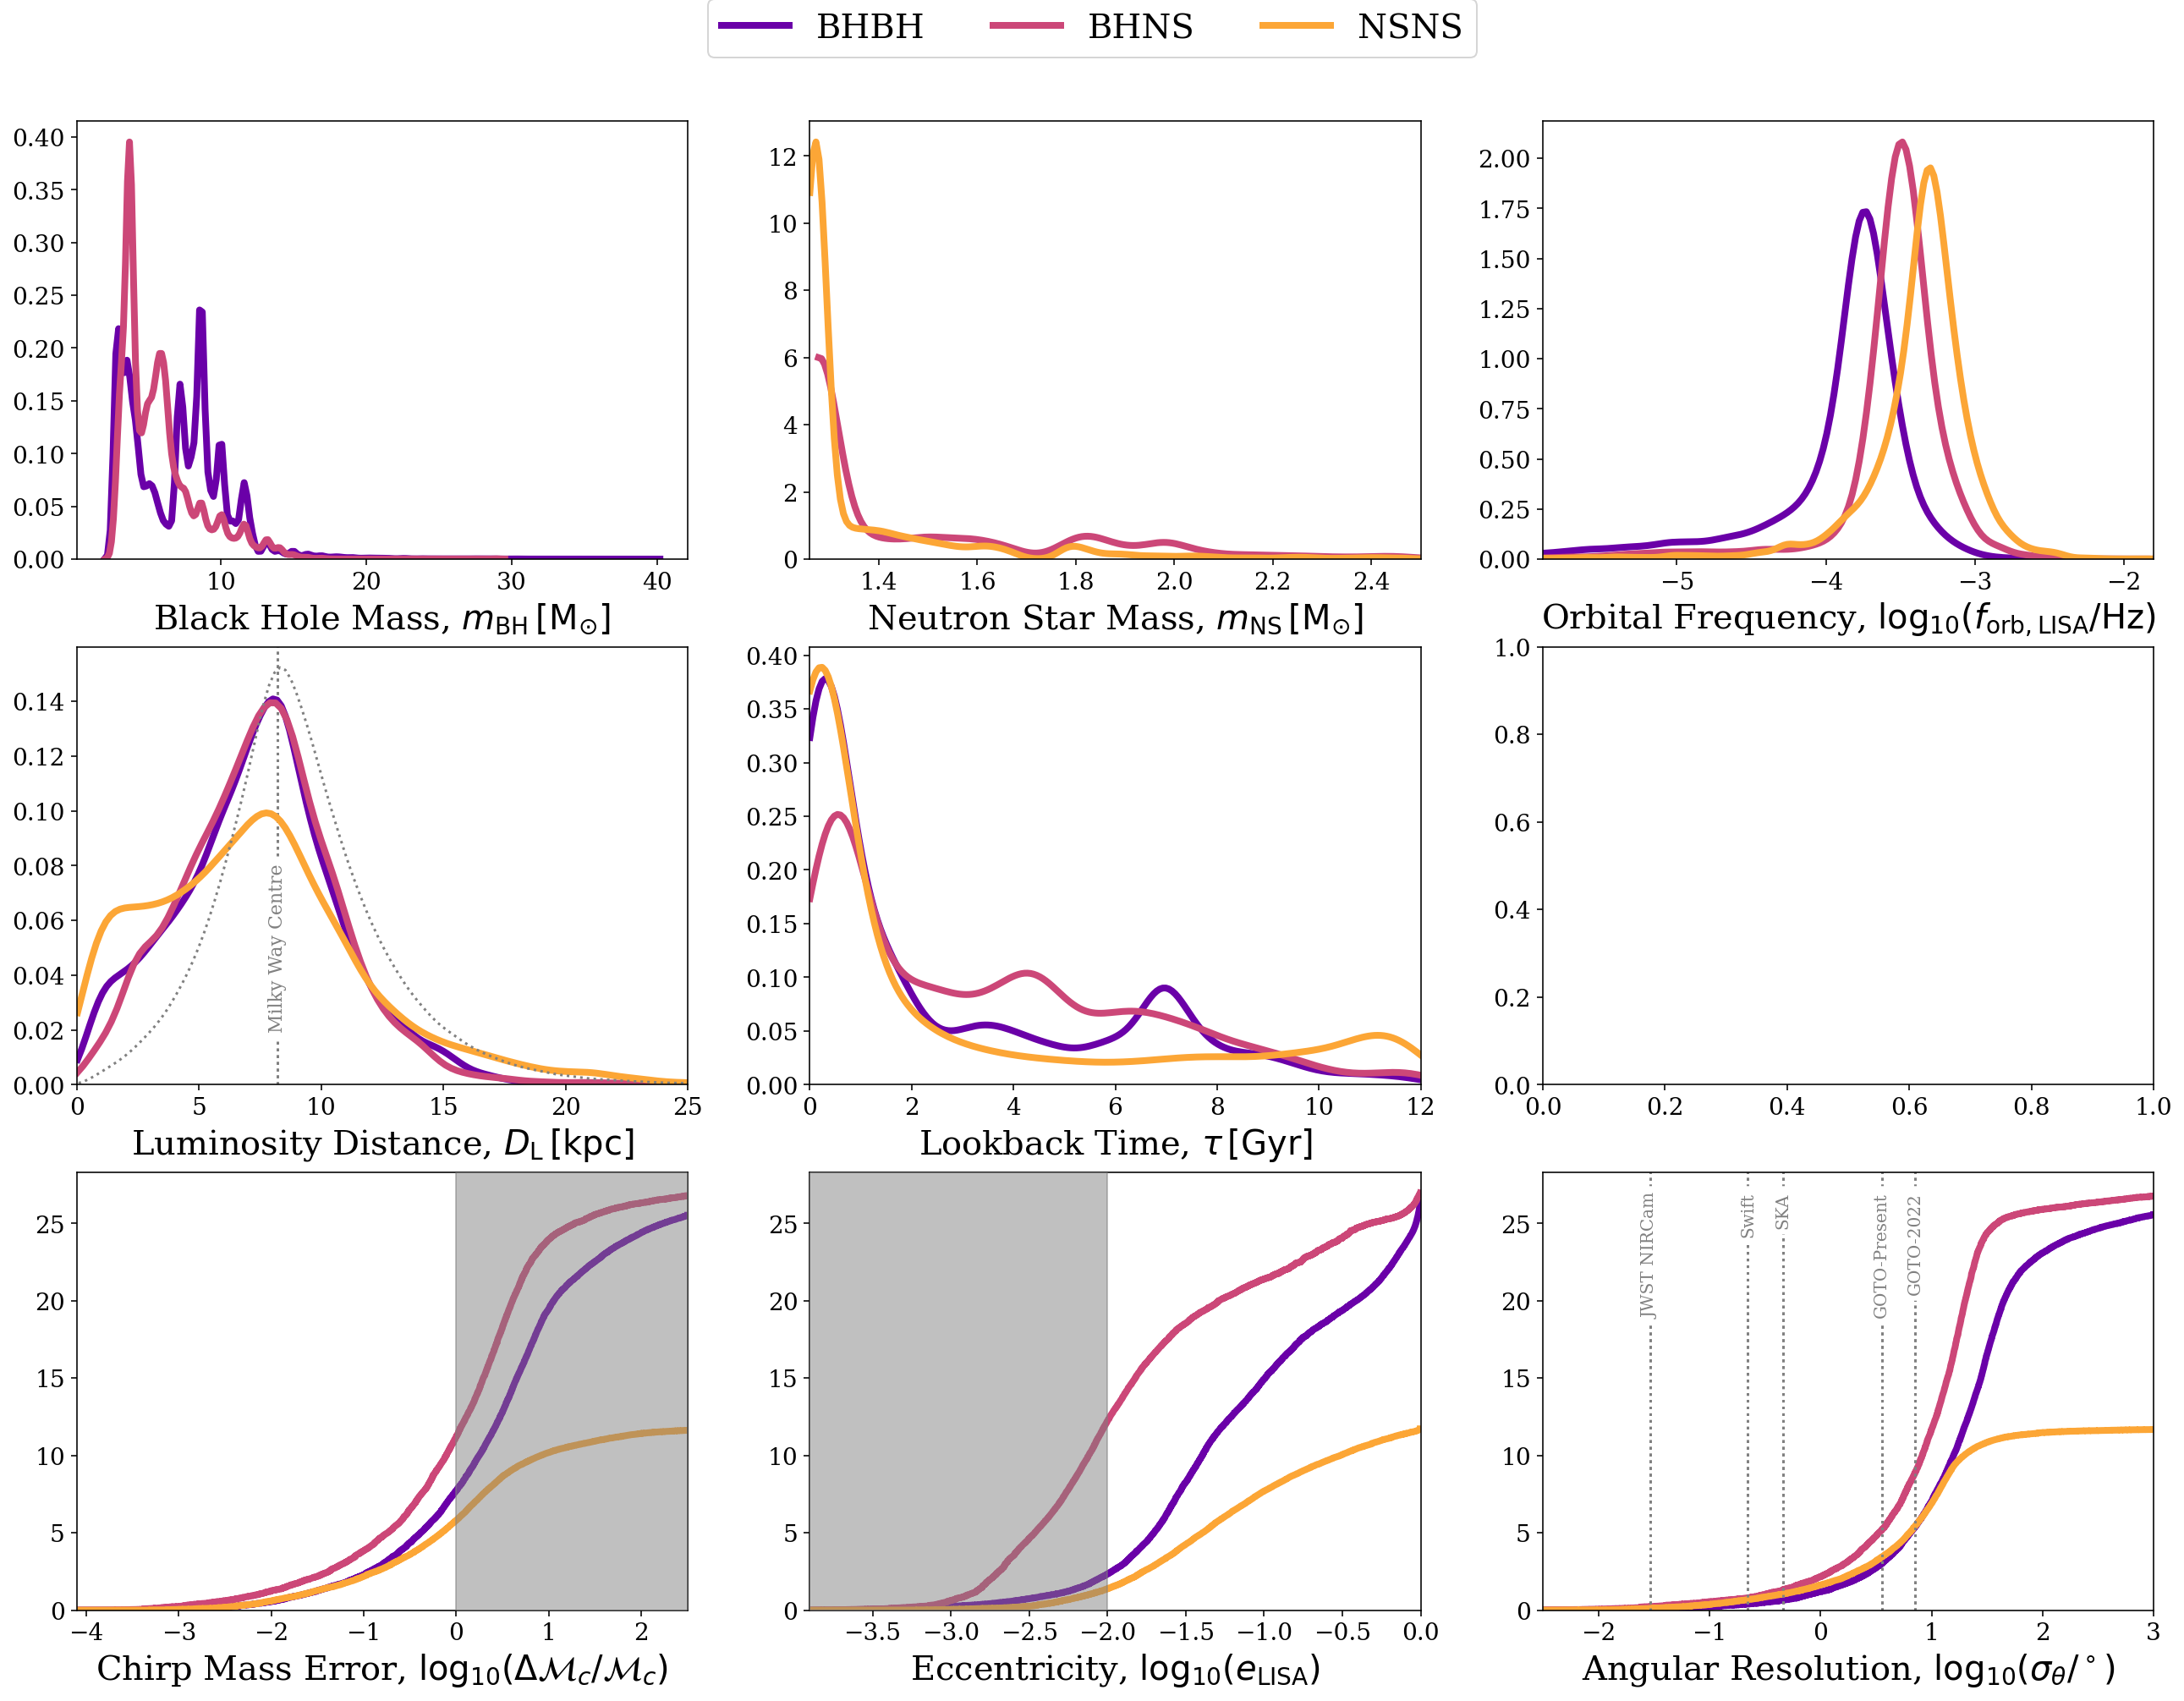

In [142]:
grid_plot()

fiducial
BHBH 9761
	Detections 41.32
	Localised detections 1.22
	Distinguished detections 5.11
	Localised AND distinguished detections 1.22
fiducial
BHNS 23730
	Detections 44.60
	Localised detections 1.96
	Distinguished detections 6.47
	Localised AND distinguished detections 1.96
fiducial
NSNS 23253
	Detections 19.30
	Localised detections 1.64
	Distinguished detections 3.42
	Localised AND distinguished detections 1.63


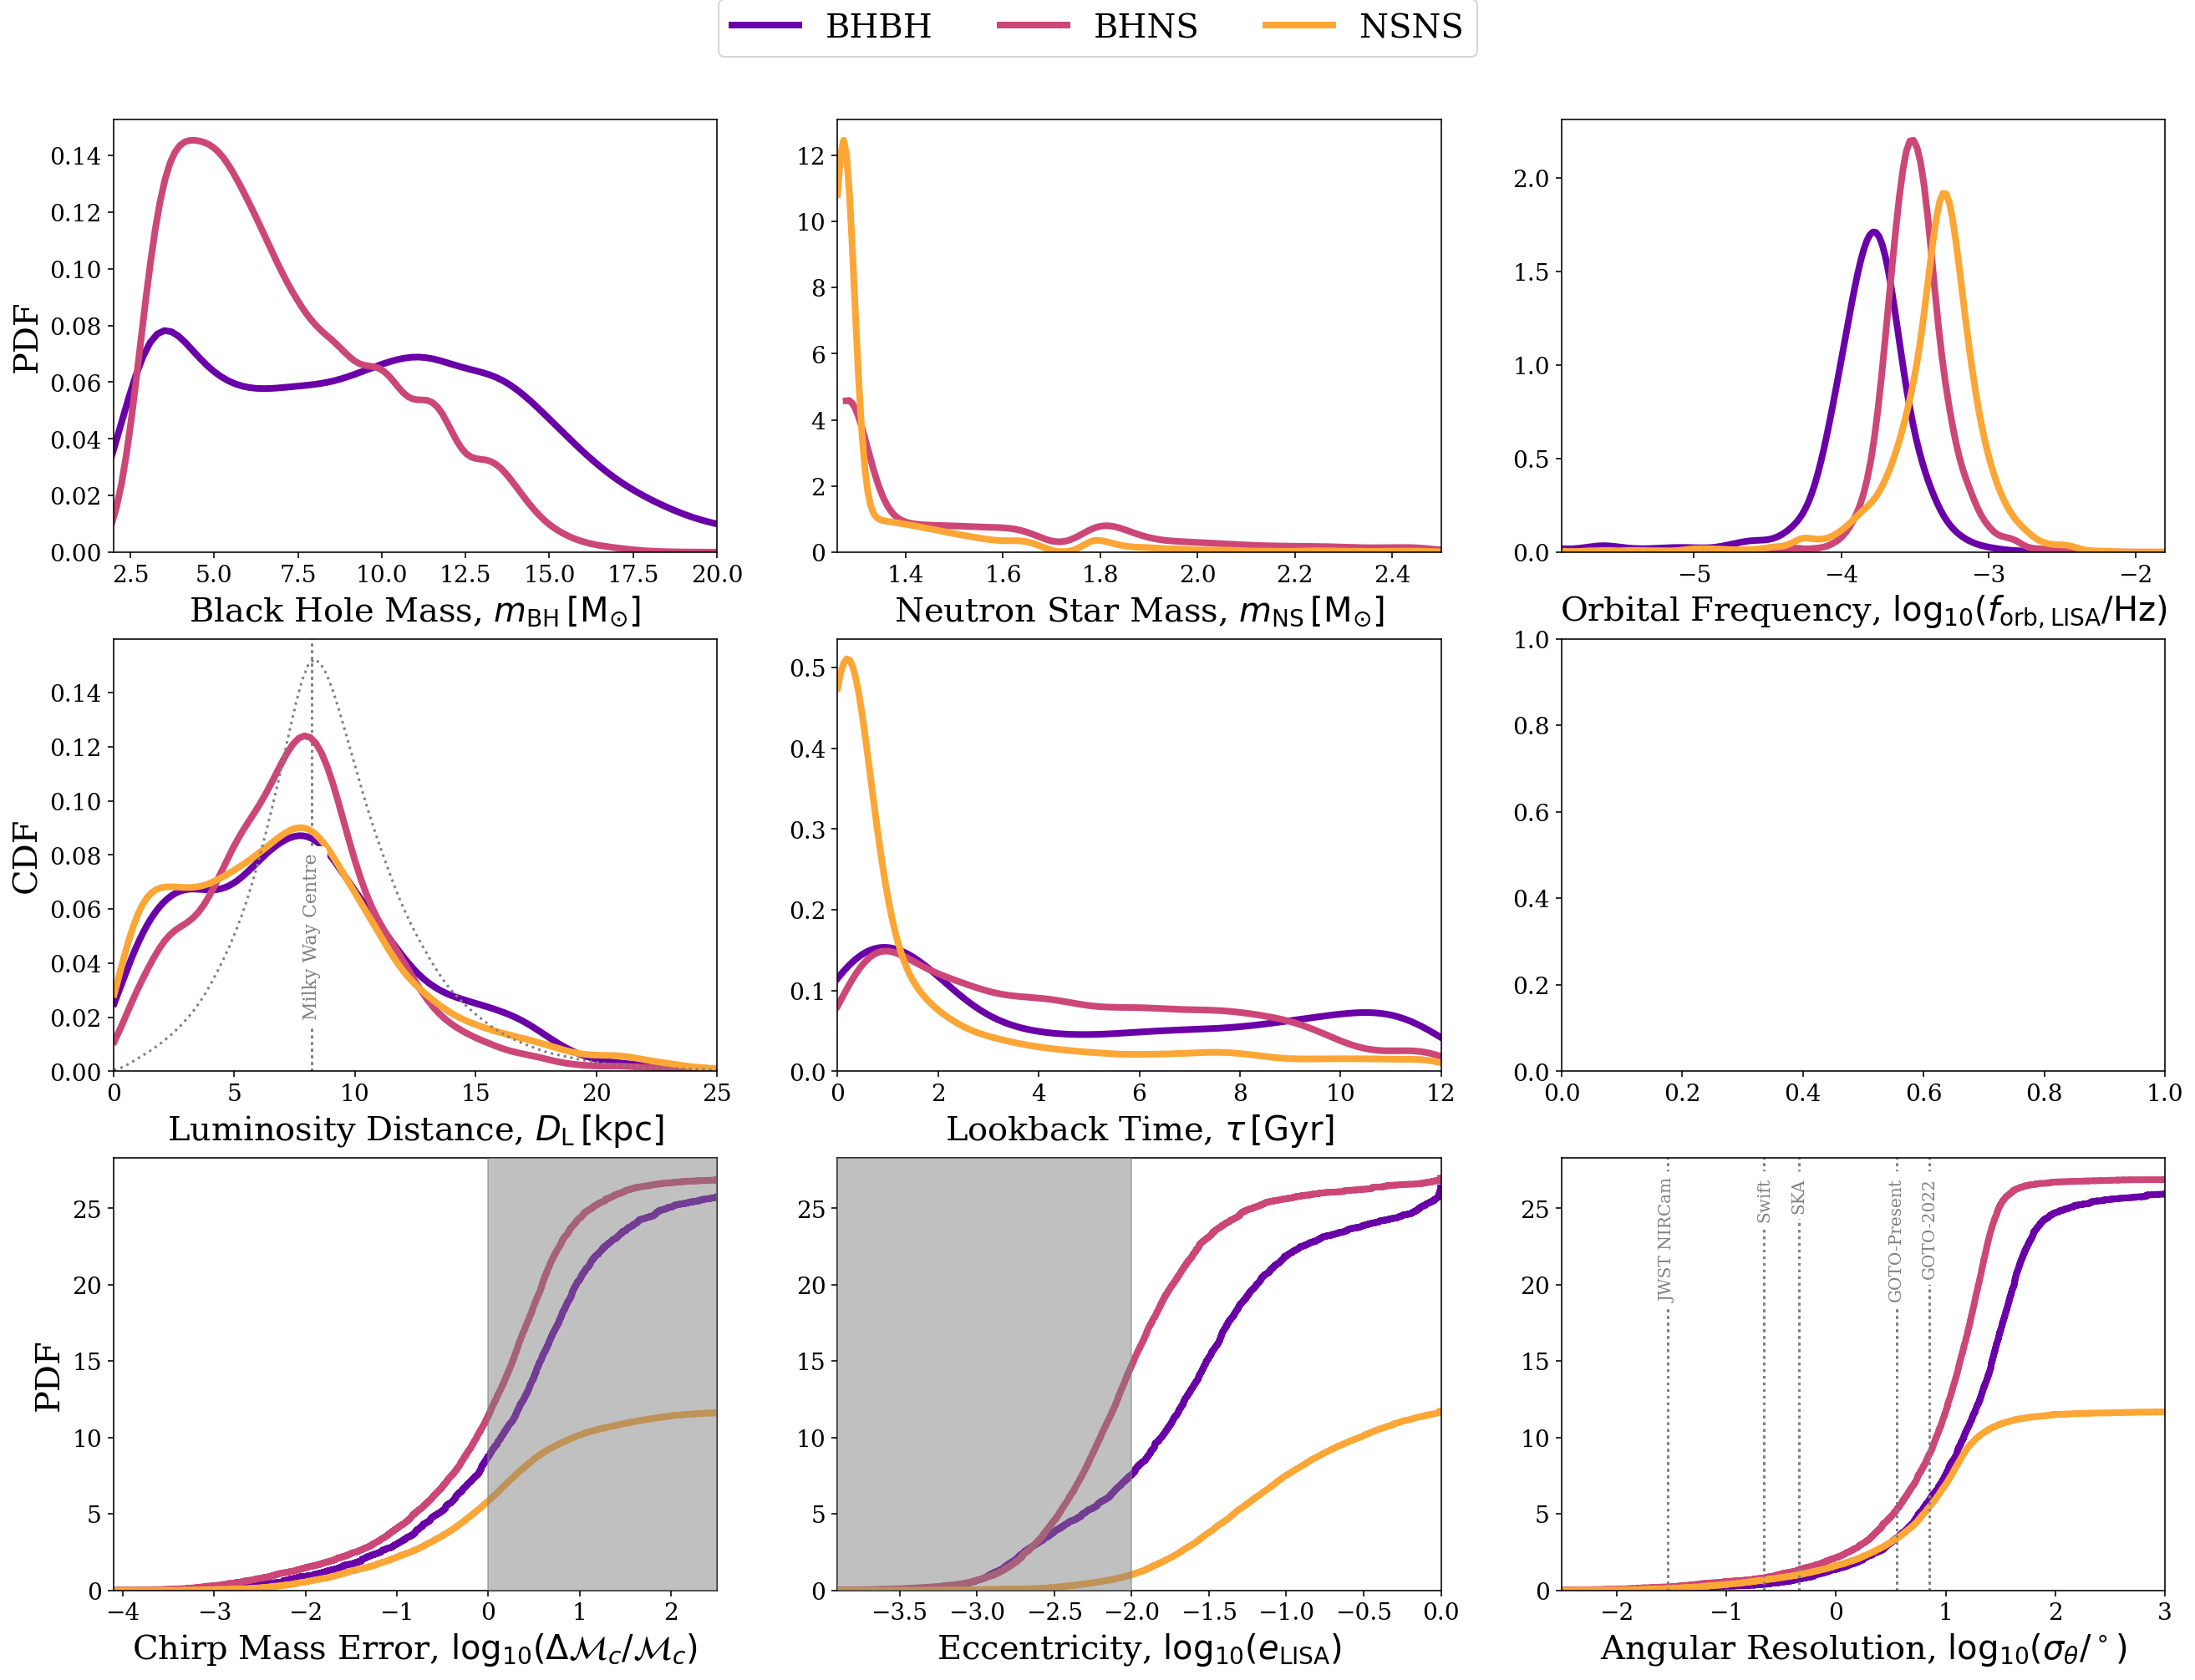

In [148]:
grid_plot(unique=True)

BHBH
BHBH 0.8409732658675376
26.336677387188097
BHNS
BHNS 0.9022730064545152
BHNS 0.6817360992657384
26.95371268596319
NSNS
NSNS 0.8616145046172456
11.716277693183638


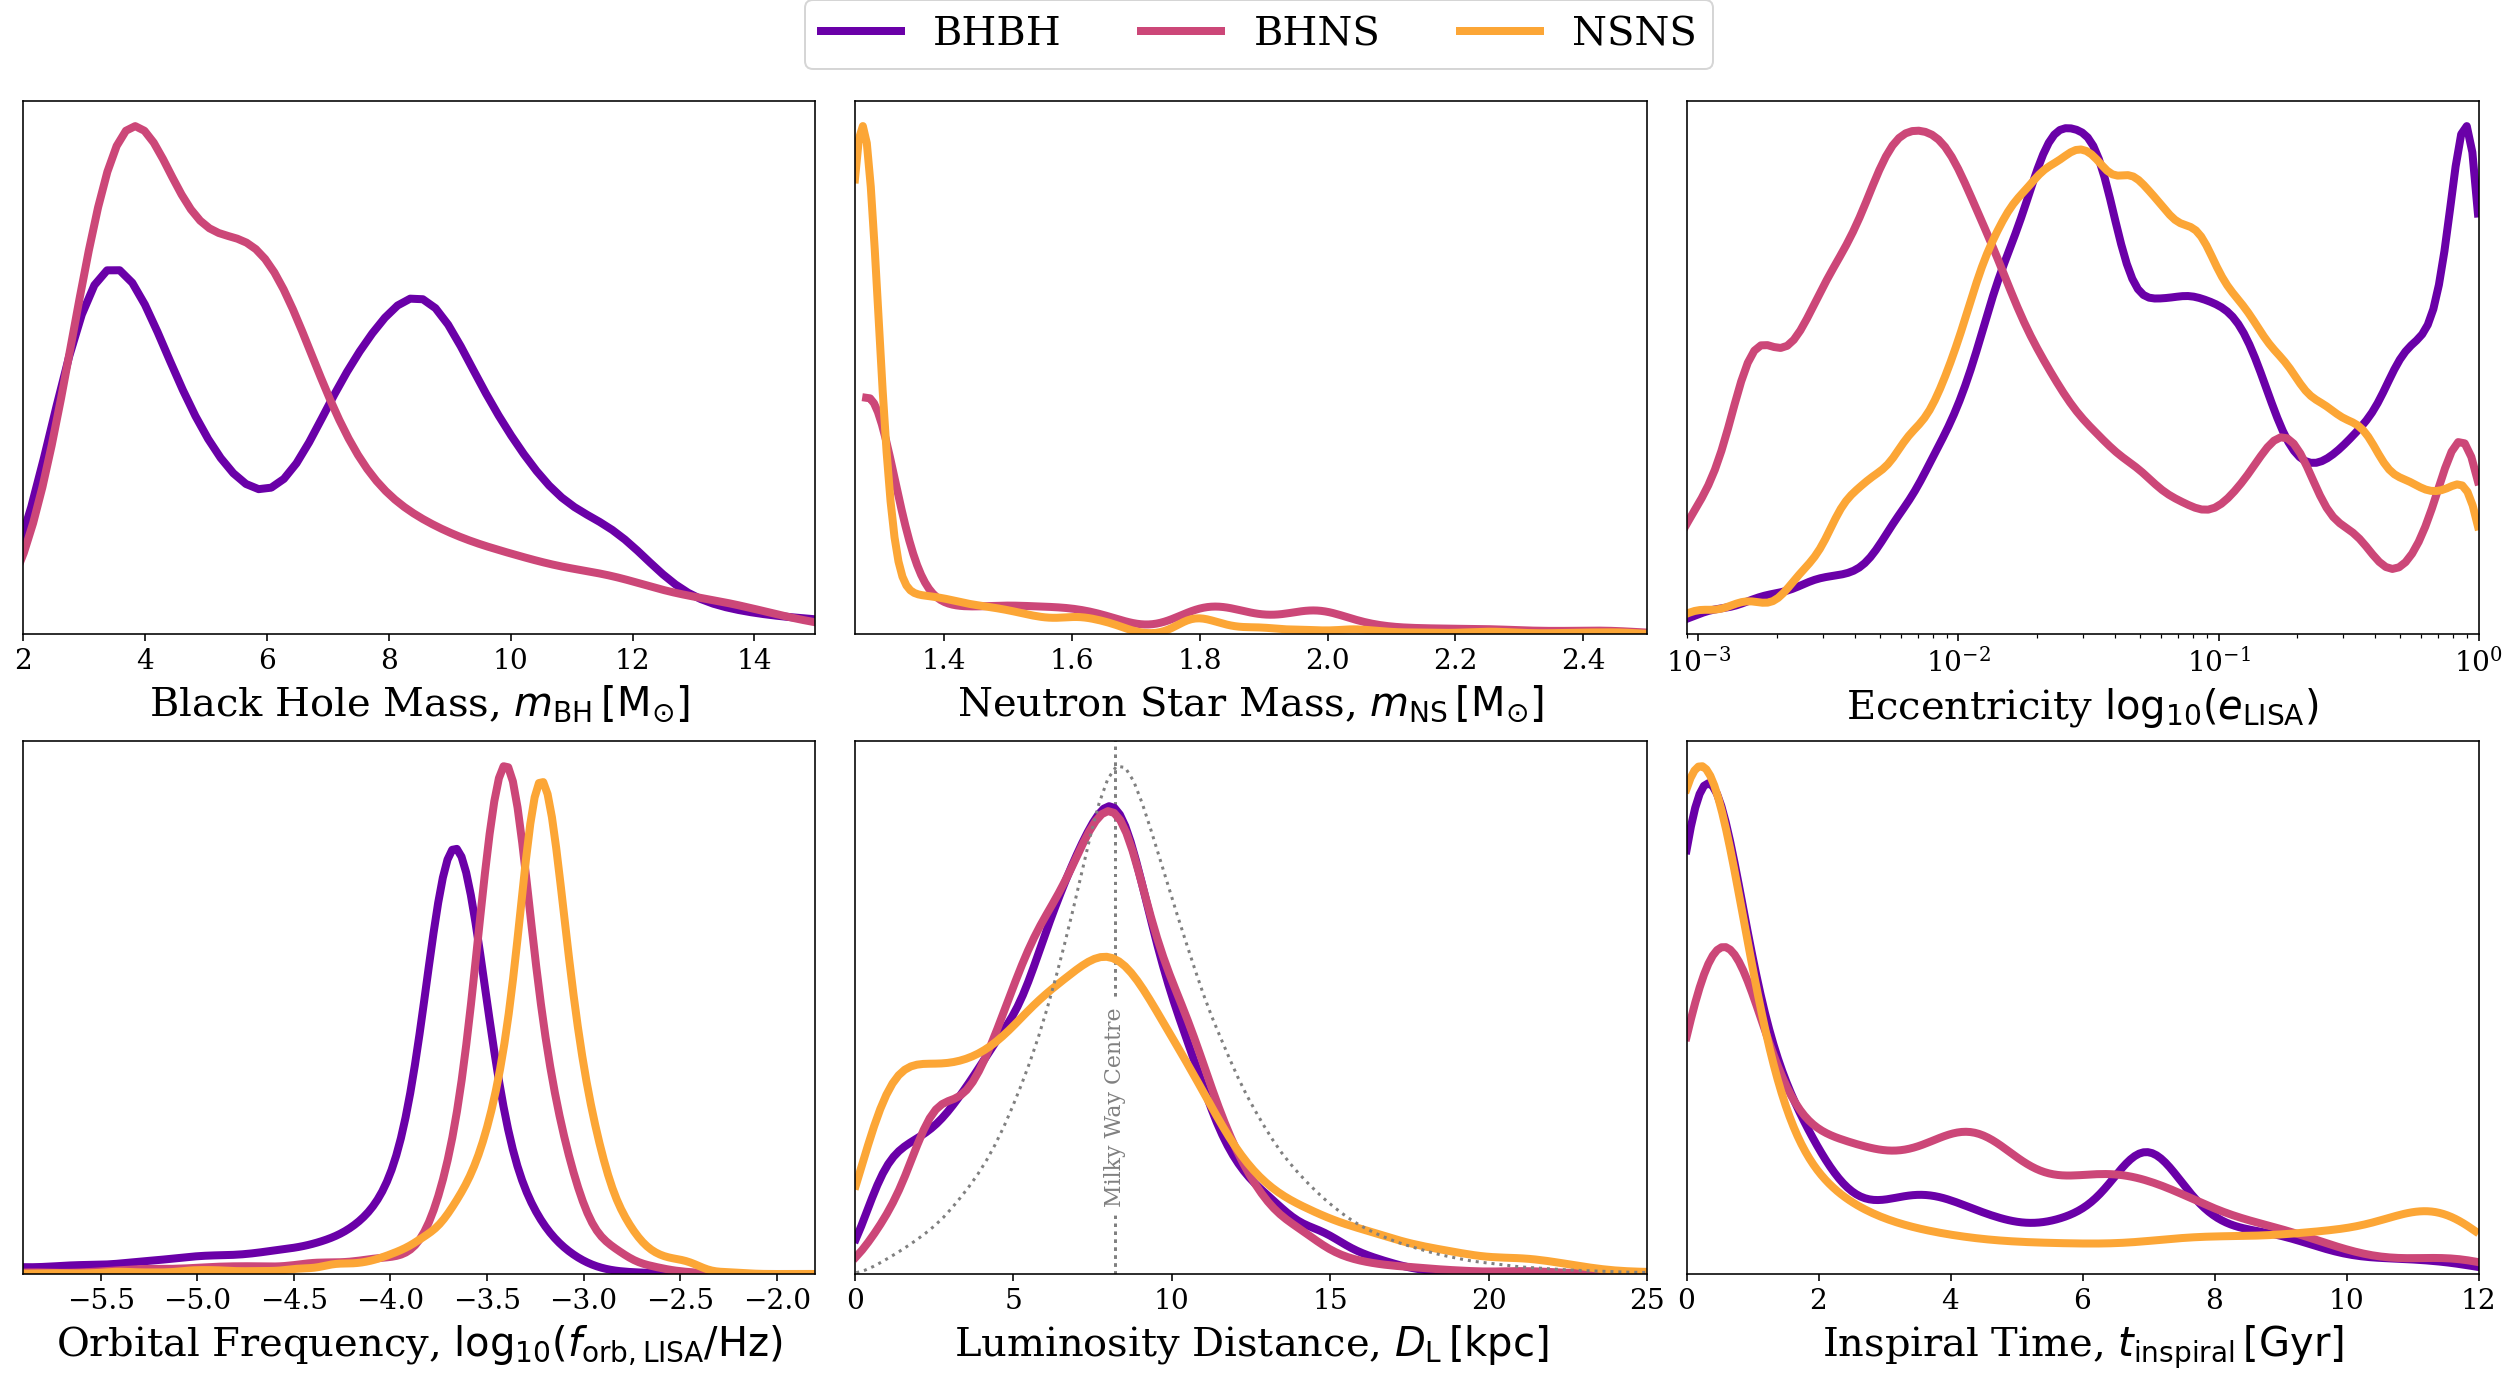

In [9]:
def distribution_pdf_grid_plot(model=0, t_obs=4*u.yr, overlay_single_mass_pdfs=False):
    fig, axes = plt.subplots(2, 3, figsize=(22, 10))

    plt.subplots_adjust(wspace=0.05, top=0.94)

    lw = 4

    for dco_type in ["BHBH", "BHNS", "NSNS"]:
        print(dco_type)
        with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[model]["file"]), "r") as f:
            full_data = f["simulation"][...].squeeze()
            snr_mask = full_data["snr"] * (t_obs / (4 * u.yr))**(0.5) > 7

            data = full_data[snr_mask]

        m_c = legwork.utils.chirp_mass(data["m_1"], data["m_2"]) * u.Msun
        f_orb_LISA = legwork.utils.get_f_orb_from_a(m_1=data["m_1"] * u.Msun, m_2=data["m_2"] * u.Msun,
                                              a=data["a_LISA"] * u.AU)
        f_dot = legwork.utils.fn_dot(m_c=m_c, f_orb=f_orb_LISA, e=data["e_LISA"], n=1)
        sigma_theta = sky_localisation(data["snr"], f_orb_LISA * 2).to(u.deg)
        
        t_merge = legwork.evol.get_t_merge_ecc(ecc_i=data["e_DCO"], a_i=data["a_DCO"] * u.AU,
                                          m_1=data["m_1"] * u.Msun, m_2=data["m_2"] * u.Msun).to(u.Gyr)

        if dco_type == "BHNS":
            mBH = np.maximum(data["m_1"], data["m_2"])
            mNS = np.minimum(data["m_1"], data["m_2"])
            mass_weights = data["weight"]
        elif dco_type == "BHBH":
            mBH = np.concatenate((data["m_1"], data["m_2"]))
            mass_weights = np.concatenate((data["weight"], data["weight"]))
        elif dco_type == "NSNS":
            mNS = np.concatenate((data["m_1"], data["m_2"]))
            mass_weights = np.concatenate((data["weight"], data["weight"]))
            
        if dco_type in ["BHNS", "BHBH"]:
            print(dco_type, np.sum(mass_weights[mBH < 10]) / np.sum(mass_weights))
            sns.kdeplot(mBH, weights=mass_weights, ax=axes[0, 0], bw_adjust=1.5, color=dco_colours[dco_type], lw=lw, label=dco_type)
            axes[0, 0].set_xlabel(r"Black Hole Mass, $m_{\rm BH} \, [\rm M_{\odot}]$")
            axes[0, 0].set_xlim(2, 15)

        if dco_type == "BHBH" and overlay_single_mass_pdfs:
            twinned = axes[0, 0].twinx()
            sns.kdeplot(data["m_1"], weights=data["weight"], ax=twinned, bw_adjust=1.5, color=dco_colours[dco_type], label=dco_type, linestyle="dotted")
            sns.kdeplot(data["m_2"], weights=data["weight"], ax=twinned, bw_adjust=1.5, color=dco_colours[dco_type], label=dco_type, linestyle="dotted")
            twinned.set_xlim(axes[0,0].get_xlim())
            twinned.set_ylim(axes[0, 0].get_ylim()[0], axes[0, 0].get_ylim()[1] * 3)
            twinned.set_yticks([])
            twinned.set_ylabel("")

        if dco_type in ["BHNS", "NSNS"]:
            print(dco_type, np.sum(mass_weights[mNS < 1.5]) / np.sum(mass_weights))
            sns.kdeplot(mNS, weights=mass_weights, ax=axes[0, 1], bw_adjust=0.8, color=dco_colours[dco_type], cut=0, lw=lw, label=dco_type)
            axes[0, 1].set_xlabel(r"Neutron Star Mass, $m_{\rm NS} \, [\rm M_{\odot}]$")
            axes[0, 1].set_xlim(1.26, 2.5)

        sns.kdeplot(data["e_LISA"], weights=data["weight"], ax=axes[0, 2], bw_adjust=0.5, color=dco_colours[dco_type], cut=0, lw=lw, label=dco_type, log_scale=True)
        axes[0, 2].set_xlabel(r"Eccentricity $\log_{10}(e_{\rm LISA})$")
        axes[0, 2].set_xlim(9e-4, 1)
    
        sns.kdeplot(np.log10(f_orb_LISA.value), weights=data["weight"], ax=axes[1, 0], bw_adjust=1, color=dco_colours[dco_type], cut=0, lw=lw, label=dco_type)
        axes[1, 0].set_xlabel(r"Orbital Frequency, $\log_{10}(f_{\rm orb, LISA} / {\rm Hz})$")
        axes[1, 0].set_xlim(-5.9, -1.8)

        print(detections[dco_types.index(dco_type)][0].mean())
        sns.kdeplot(data["dist"], weights=data["weight"], ax=axes[1, 1], bw_adjust=1, color=dco_colours[dco_type], cut=0, lw=lw, label=dco_type)
        axes[1, 1].set_xlabel(r"Luminosity Distance, $D_{\rm L} \, [\rm kpc]$")
        axes[1, 1].set_xlim(0, 25)
        axes[1, 1].axvline(8.2, color="grey", linestyle="dotted", zorder=0)
        axes[1, 1].annotate("Milky Way Centre", xy=(8.2, 0.05), color="grey", rotation=90, ha="center", va="center",
                            bbox=dict(boxstyle="round", ec="white", fc="white"), fontsize=0.55*fs)
        
        sns.kdeplot(t_merge.value, weights=data["weight"], ax=axes[1, 2], bw_adjust=1, color=dco_colours[dco_type], lw=lw, label=dco_type, cut=0)
        axes[1, 2].set_xlabel(r"Inspiral Time, $t_{\rm inspiral} \, [\rm Gyr]$")
        axes[1, 2].set_xlim(0, 12)
        
#         sns.kdeplot(np.log10(data["Z"]), weights=data["weight"], ax=axes[1, 2], cut=0, bw_adjust=1.5, color=dco_colours[dco_type], lw=lw, label=dco_type)
        
    tau, D, Z = simulate_mw(int(1e6))
    sns.kdeplot(D, ax=axes[1, 1], color="grey", bw_adjust=1.5, linestyle="dotted", cut=0)
    
    handles, labels = axes[1, 2].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', fontsize=fs, ncol=3, borderaxespad=0.0)

    for ax in axes.flatten():
        ax.tick_params(labelsize=0.7*fs)
        ax.set_yticks([])
        ax.set_ylabel("")
        ax.xaxis.label.set_fontsize(fs)

#     plt.savefig("../plots/fiducial_pdf_distributions.pdf", format="pdf", bbox_inches="tight")

    plt.show()
    
distribution_pdf_grid_plot(model=0, t_obs=4*u.yr)

In [10]:
def kdeplot_something(variable, dco_type_list=["BHBH", "BHNS", "NSNS"], variation_index=0, show=True):
    fig, ax = plt.subplots(1, figsize=(10, 5))

    for dco_type in dco_type_list:
        with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[variation_index]["file"]), "r") as f:
            full_data = f["simulation"][...].squeeze()
            snr_mask = full_data["snr"] > 7

            data = full_data[snr_mask]

        sns.kdeplot(data[variable], weights=data["weight"], color=dco_colours[dco_type], cut=0, lw=4)

    if show:
        plt.show()
    return fig, ax

## CDFs for constraining stuff

fiducial
BHBH
	Detections 26.34
	Localised detections 1.05
	Distinguished detections 1.73
	Localised AND distinguished detections 0.96
fiducial
BHNS
	Detections 26.95
	Localised detections 2.03
	Distinguished detections 3.07
	Localised AND distinguished detections 2.00
fiducial
NSNS
	Detections 11.72
	Localised detections 1.64
	Distinguished detections 1.82
	Localised AND distinguished detections 1.58


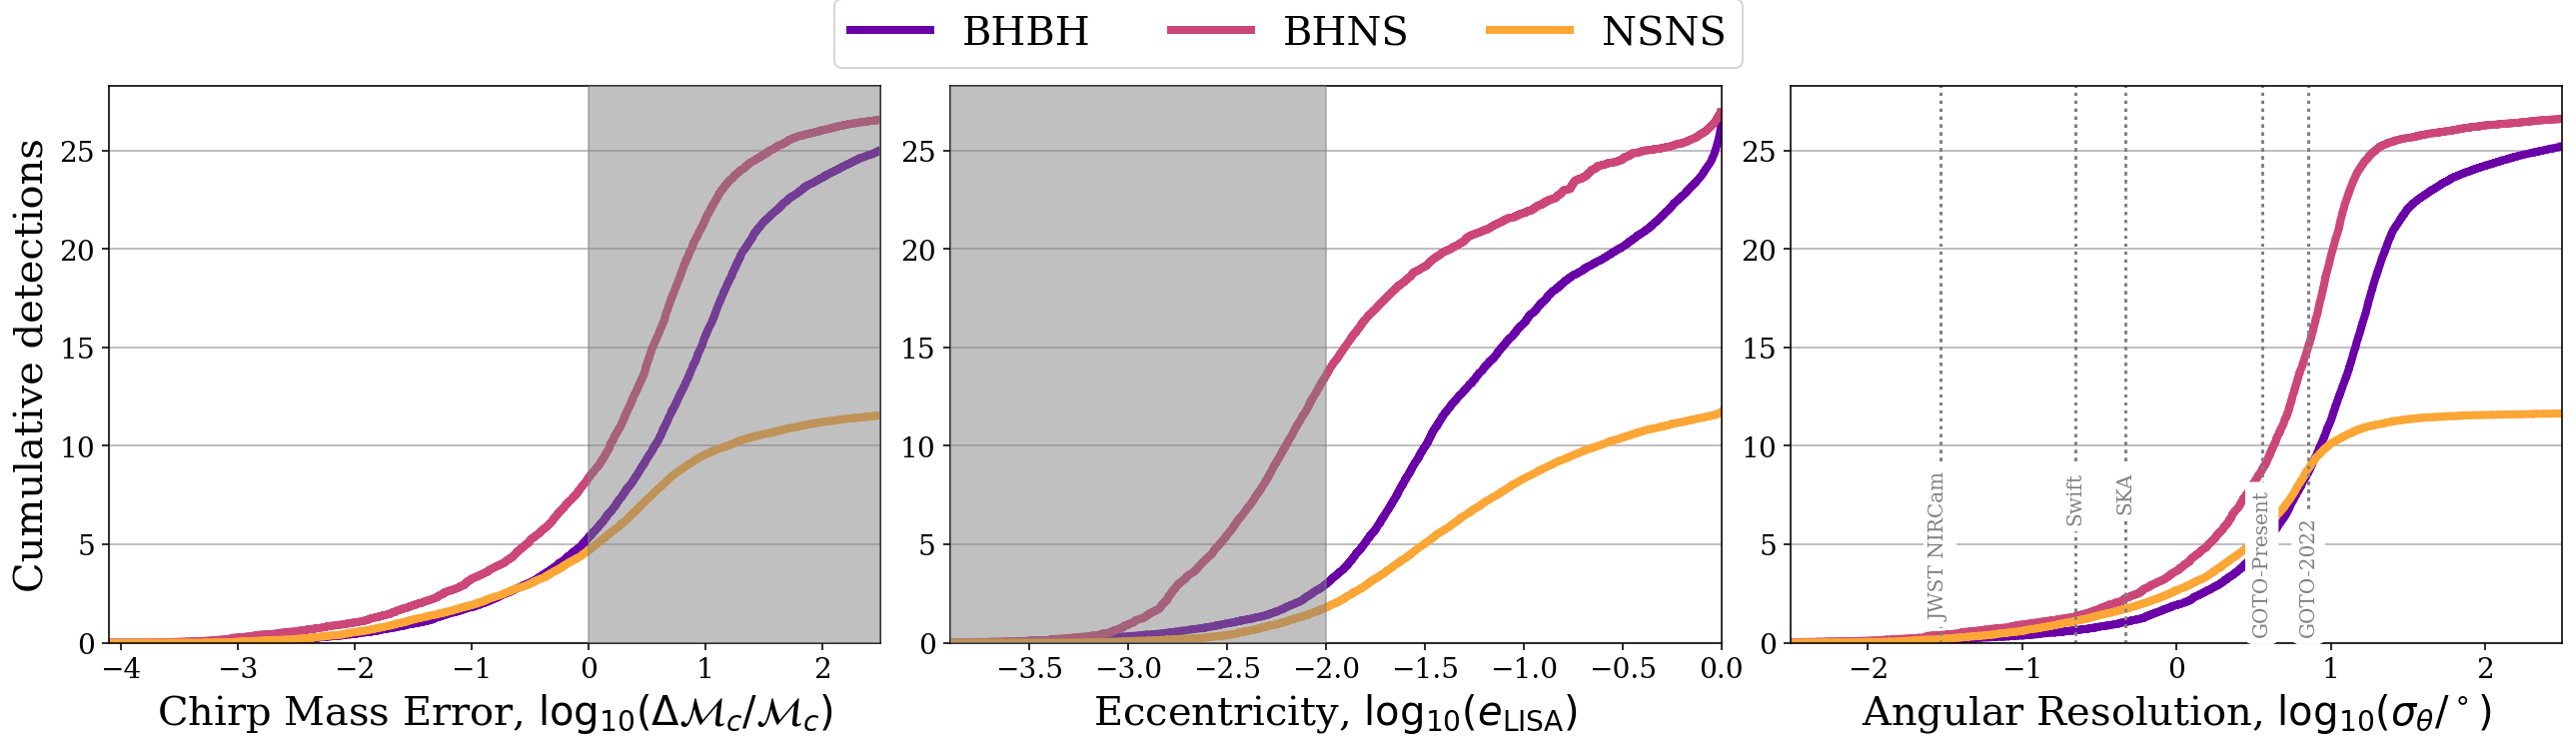

In [11]:
def distribution_cdf_grid_plot(model=0, t_obs=4*u.yr):
    fig, axes = plt.subplots(1, 3, figsize=(22, 5))

    plt.subplots_adjust(wspace=0.09, top=0.90)

    lw = 4

    for dco_type in ["BHBH", "BHNS", "NSNS"]:
        with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[model]["file"]), "r") as f:
            full_data = f["simulation"][...].squeeze()
            snr_mask = full_data["snr"]  > 7

            data = full_data[snr_mask]

        m_c = legwork.utils.chirp_mass(data["m_1"], data["m_2"]) * u.Msun
        f_orb_LISA = legwork.utils.get_f_orb_from_a(m_1=data["m_1"] * u.Msun, m_2=data["m_2"] * u.Msun,
                                              a=data["a_LISA"] * u.AU)
        f_dot = legwork.utils.fn_dot(m_c=m_c, f_orb=f_orb_LISA, e=data["e_LISA"], n=1)
        sigma_theta = sky_localisation(data["snr"], f_orb_LISA * 2).to(u.deg)
        
        t_merge = legwork.evol.get_t_merge_ecc(ecc_i=data["e_DCO"], a_i=data["a_DCO"] * u.AU,
                                          m_1=data["m_1"] * u.Msun, m_2=data["m_2"] * u.Msun).to(u.Gyr)

        D_fdot = fdot_uncertainty(data["snr"] , t_obs, f_dot)
        D_f = f_uncertainty(data["snr"], t_obs, f_orb_LISA)
        D_e = np.where(nharm[dco_type] > 1, 0.05, np.where(nharm[dco_type] == 0, 1, 0.1))
        D_Mc = 11 / 5 * D_f + 3 / 5 * D_fdot + 3 / 5 * Fprime_over_F(data["e_LISA"]) * D_e

        localised = sigma_theta <= np.sqrt(0.67 / np.pi) * u.deg
        distinguished = D_Mc <= 0.1
        print(variations[model]["med"])
        print(dco_type)
        print("\tDetections {:1.2f}".format(detections[dco_types.index(dco_type)][model].mean()))
        print("\tLocalised detections {:1.2f}".format(detections[dco_types.index(dco_type)][model].mean() * len(data[localised]) / len(data)))
        print("\tDistinguished detections {:1.2f}".format(detections[dco_types.index(dco_type)][model].mean() * len(data[distinguished]) / len(data)))
        print("\tLocalised AND distinguished detections {:1.2f}".format(detections[dco_types.index(dco_type)][model].mean() * len(data[np.logical_and(localised, distinguished)]) / len(data)))
        
        sns.ecdfplot(x=np.log10(D_Mc.value), weights=data["weight"] / np.sum(data["weight"]) * detections[dco_types.index(dco_type)][model].mean(),
                     ax=axes[0], color=dco_colours[dco_type], lw=lw, label=dco_type, stat="count")
        axes[0].set_xlabel(r"Chirp Mass Error, $\log_{10}(\Delta \mathcal{M}_c / \mathcal{M}_c)$")
        axes[0].set_xlim(-4.1, 2.5)
        axes[0].axvspan(0, axes[0].get_xlim()[1], color="grey", zorder=10, alpha=0.2)

        sns.ecdfplot(x=np.log10(data["e_LISA"]), weights=data["weight"] / np.sum(data["weight"]) * detections[dco_types.index(dco_type)][model].mean(),
                     ax=axes[1], color=dco_colours[dco_type], lw=lw, label=dco_type, stat="count")
        axes[1].set_xlabel(r"Eccentricity, $\log_{10}(e_{\rm LISA})$")
        axes[1].set_xlim(-3.9, 0)
        axes[1].axvspan(axes[1].get_xlim()[0], -2, color="grey", zorder=10, alpha=0.2)
        
        sns.ecdfplot(x=np.log10(sigma_theta.value), weights=data["weight"] / np.sum(data["weight"]) * detections[dco_types.index(dco_type)][model].mean(),
                     ax=axes[2], color=dco_colours[dco_type], lw=lw, label=dco_type, stat="count")
        axes[2].set_xlabel(r"Angular Resolution, $\log_{10}(\sigma_{\theta} / {\rm ^\circ})$")
        axes[2].set_xlim(-2.5, 2.5)
        
        telescopes = [("SKA", 0.67 * u.deg**2), ("JWST NIRCam", 9.7 * u.arcmin**2), ("GOTO-Present", 40 * u.deg**2), ("GOTO-2022", 160 * u.deg**2), ("Swift", (23.6 * u.arcmin)**2)]
        
        for name, area in telescopes:
            angular_resolution = np.sqrt(area / np.pi).to(u.deg)
            axes[2].axvline(np.log10(angular_resolution.value), linestyle="dotted", color="grey")
            
            y = 8.7 if np.log10(angular_resolution.value) < 0 else 0.3
            va = "top" if np.log10(angular_resolution.value) < 0 else "bottom"
            axes[2].annotate(name, xy=(np.log10(angular_resolution.value), y), xycoords="data", rotation=90,
                             ha="center", va=va, fontsize=0.5*fs, color="grey", bbox=dict(boxstyle="round", fc="white", ec="white"))
        
#         JSWT_NIRcam = np.sqrt(9.7 * u.arcmin**2 / np.pi).to(u.deg)
#         axes[2].axvline(np.log10(JSWT_NIRcam.value), linestyle="dotted", color="grey")
#         axes[2].annotate("JWST NIRCam FOV", xy=(np.log10(JSWT_NIRcam.value), 27.0), xycoords="data", rotation=90, ha="right", va="top", fontsize=0.5*fs, color="grey")

    handles, labels = axes[-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', fontsize=fs, ncol=3, borderaxespad=0.0)

    for ax in axes.flatten():
        ax.tick_params(labelsize=0.7*fs)
#         ax.set_yticks([])
        ax.grid(axis="y")
        ax.set_ylabel("")
        ax.xaxis.label.set_fontsize(fs)
        
    axes[0].set_ylabel("Cumulative detections", fontsize=fs)

#     plt.savefig("../plots/fiducial_cdf_distributions.pdf", format="pdf", bbox_inches="tight")

    plt.show()
    
distribution_cdf_grid_plot(0, 4 * u.yr)

$\dot{f}/T^2 > \pi / rho$ (or 1)

In [12]:
fid_sources = [None, None, None]
for i in range(len(dco_types)):
    with h5.File(sim_folder + "{}_fiducial_all.h5".format(dco_types[i]), "r") as f:
        full_data = f["simulation"][...].squeeze()
        snr_mask = full_data["snr"] > 7
        
        data = full_data[snr_mask]
        
    fid_sources[i] = legwork.source.Source(m_1=data["m_1"] * u.Msun, m_2=data["m_2"] * u.Msun,
                                                dist=data["dist"] * u.kpc, ecc=data["e_LISA"],
                                                a=data["a_LISA"] * u.AU)
    fid_sources[i].weight = data["weight"]

26657 7036
[14.4283 14.8422 14.7804]
22736 16125
[ 9.08826 11.6863  13.1164 ]
18207 15422
[1.26002 1.26004 1.26004]


In [13]:
for i in range(len(dco_types)):
    fid_sources[i].get_snr(verbose=True)

Calculating SNR for 26657 sources
	26653 sources are stationary
		15212 sources are stationary and circular
		11441 sources are stationary and eccentric
	4 sources are evolving
		4 sources are evolving and circular
Calculating SNR for 22736 sources
	22732 sources are stationary
		20743 sources are stationary and circular
		1989 sources are stationary and eccentric
	4 sources are evolving
		4 sources are evolving and circular
Calculating SNR for 18207 sources
	18206 sources are stationary
		10546 sources are stationary and circular
		7660 sources are stationary and eccentric
	1 sources are evolving
		1 sources are evolving and circular


In [ ]:
e_dist_line = 0.9
nmax = 220
e_sources = legwork.source.Stationary(dist=np.repeat(dist, line_length) * u.kpc,
                                  ecc=np.repeat(e_dist_line, line_length),
                                  f_orb=lines_f_range,
                                  m_1=np.repeat(fid_sources[i].m_c.min() * 2**(1/5), line_length),
                                  m_2=np.repeat(fid_sources[i].m_c.min() * 2**(1/5), line_length))
e_sources.get_snr(verbose=True)
dominant_freq = lines_f_range * e_sources.max_snr_harmonic
e_dist_line_signal = e_sources.snr * np.sqrt(legwork.psd.lisa_psd(dominant_freq))
mask = e_sources.snr > 1
axes[i].plot(dominant_freq[mask], e_dist_line_signal[mask], color="grey", linestyle="--", lw=0.7, zorder=0)

BHBH done
BHNS done
NSNS done


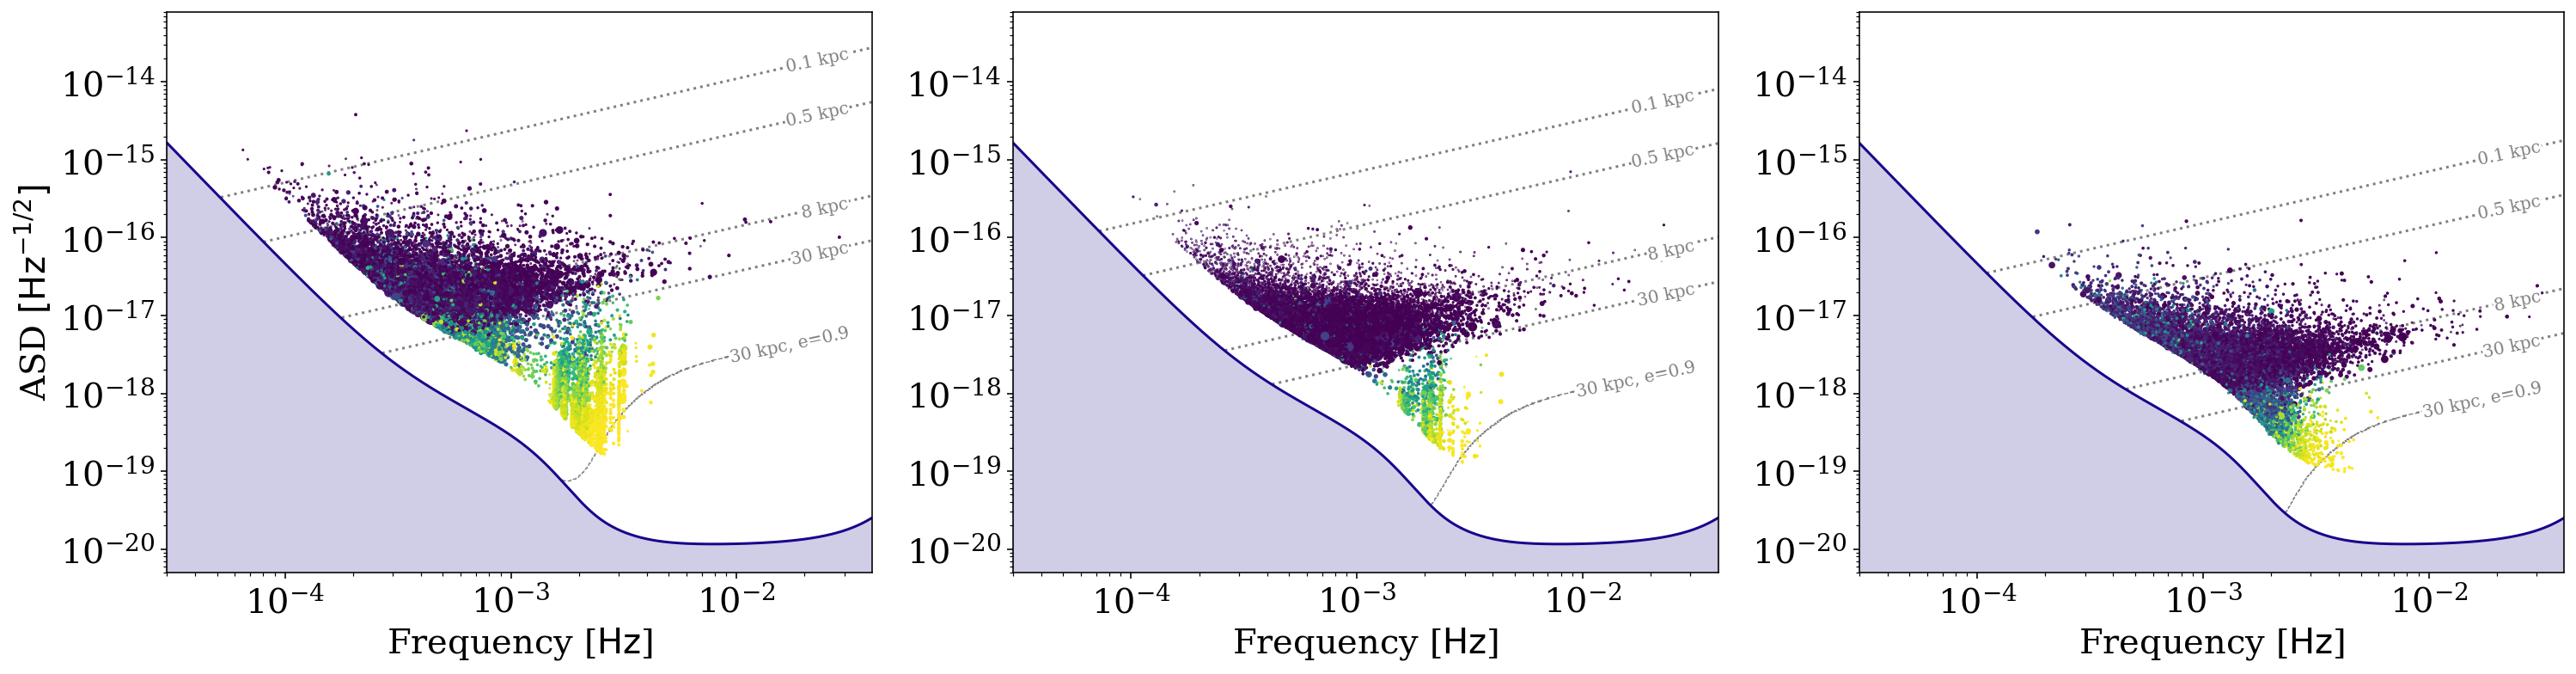

In [96]:
frequency_range = np.logspace(np.log10(3e-5), -1.4, 1000) * u.Hz

fig, axes = plt.subplots(1, 3, figsize=(25, 6))

for i in range(len(dco_types)):
    legwork.visualisation.plot_sensitivity_curve(show=False, frequency_range=frequency_range, fig=fig, ax=axes[i])
    
    line_length = 1000
    lines_f_range = np.logspace(-6.5, -1.4, line_length) * u.Hz
    for dist in [0.1, 0.5, 8, 30]:
        dist_line_signal = np.sqrt(4 * u.yr).to(u.Hz**(-1/2))\
            * legwork.strain.h_0_n(m_c=np.repeat(fid_sources[i].m_c.mean(), line_length),
                                   dist=np.repeat(dist, line_length) * u.kpc, 
                                   f_orb=lines_f_range,
                                   n=2,
                                   ecc=np.zeros(line_length))[:, 0, 0]
        mask = dist_line_signal > np.sqrt(legwork.psd.lisa_psd(lines_f_range * 2))
        axes[i].plot(lines_f_range[mask] * 2, dist_line_signal[mask], color="grey", linestyle="dotted", zorder=0)
        axes[i].annotate("{} kpc".format(dist), xy=(lines_f_range[mask][-20].value, dist_line_signal[mask][-20].value * 0.5), xycoords="data", color="grey", rotation=12, 
                         ha="right", va="center", fontsize=10, bbox=dict(boxstyle="round", ec="white", fc="white", pad=0.0))
        
    for e_dist_line in [0.9]:
        nmax = 220 if e_dist_line == 0.9 else 7000
        e_sources = legwork.source.Stationary(dist=np.repeat(dist, line_length) * u.kpc,
                                          ecc=np.repeat(e_dist_line, line_length),
                                          f_orb=lines_f_range,
                                          m_1=np.repeat(fid_sources[i].m_c.min() * 2**(1/5), line_length),
                                          m_2=np.repeat(fid_sources[i].m_c.min() * 2**(1/5), line_length))
        e_sources.get_snr()
        dominant_freq = lines_f_range * e_sources.max_snr_harmonic
        e_dist_line_signal = e_sources.snr * np.sqrt(legwork.psd.lisa_psd(dominant_freq))
        check = np.argmin(np.diff(dominant_freq))
        mask = e_sources.snr[:check] > 1
        axes[i].plot(dominant_freq[:check][mask], e_dist_line_signal[:check][mask], lw=0.7, zorder=0, color="grey", linestyle="--")
    
    ind = -50
    axes[i].annotate("{} kpc, e={}".format(dist, e_dist_line), xy=(dominant_freq[:check][mask][ind].value, e_dist_line_signal[:check][mask][ind].value), xycoords="data", color="grey",
                     rotation=12, ha="center", va="center", fontsize=10, bbox=dict(boxstyle="round", ec="white", fc="white", pad=0.0))

    legwork.visualisation.plot_sources_on_sc_ecc_stat(f_dom=fid_sources[i].f_orb * fid_sources[i].max_snr_harmonic,
                                                      snr=fid_sources[i].snr, fig=fig, ax=axes[i], show=False, c=fid_sources[i].ecc, s=fid_sources[i].weight * 25)
    print(dco_types[i], "done")
    
# fig.colorbar(scatter)    

ylims = (5e-21, 8e-14)
    
for ax in axes:
    if ax != axes[0]:
        ax.set_ylabel("")
    ax.tick_params(labelsize=fs)
    ax.xaxis.label.set_fontsize(fs)
    ax.yaxis.label.set_fontsize(fs)
    ax.set_ylim(ylims)
    
# fig.legend(loc='upper center', fontsize=fs, markerscale=20, ncol=3, handletextpad=0, borderaxespad=0.0)

# plt.savefig("../plots/dcos_on_sc.pdf", format="pdf", bbox_inches="tight")
# plt.savefig("../plots/dcos_on_sc.png", bbox_inches="tight")

plt.show()

BHBH done
BHNS done
NSNS done


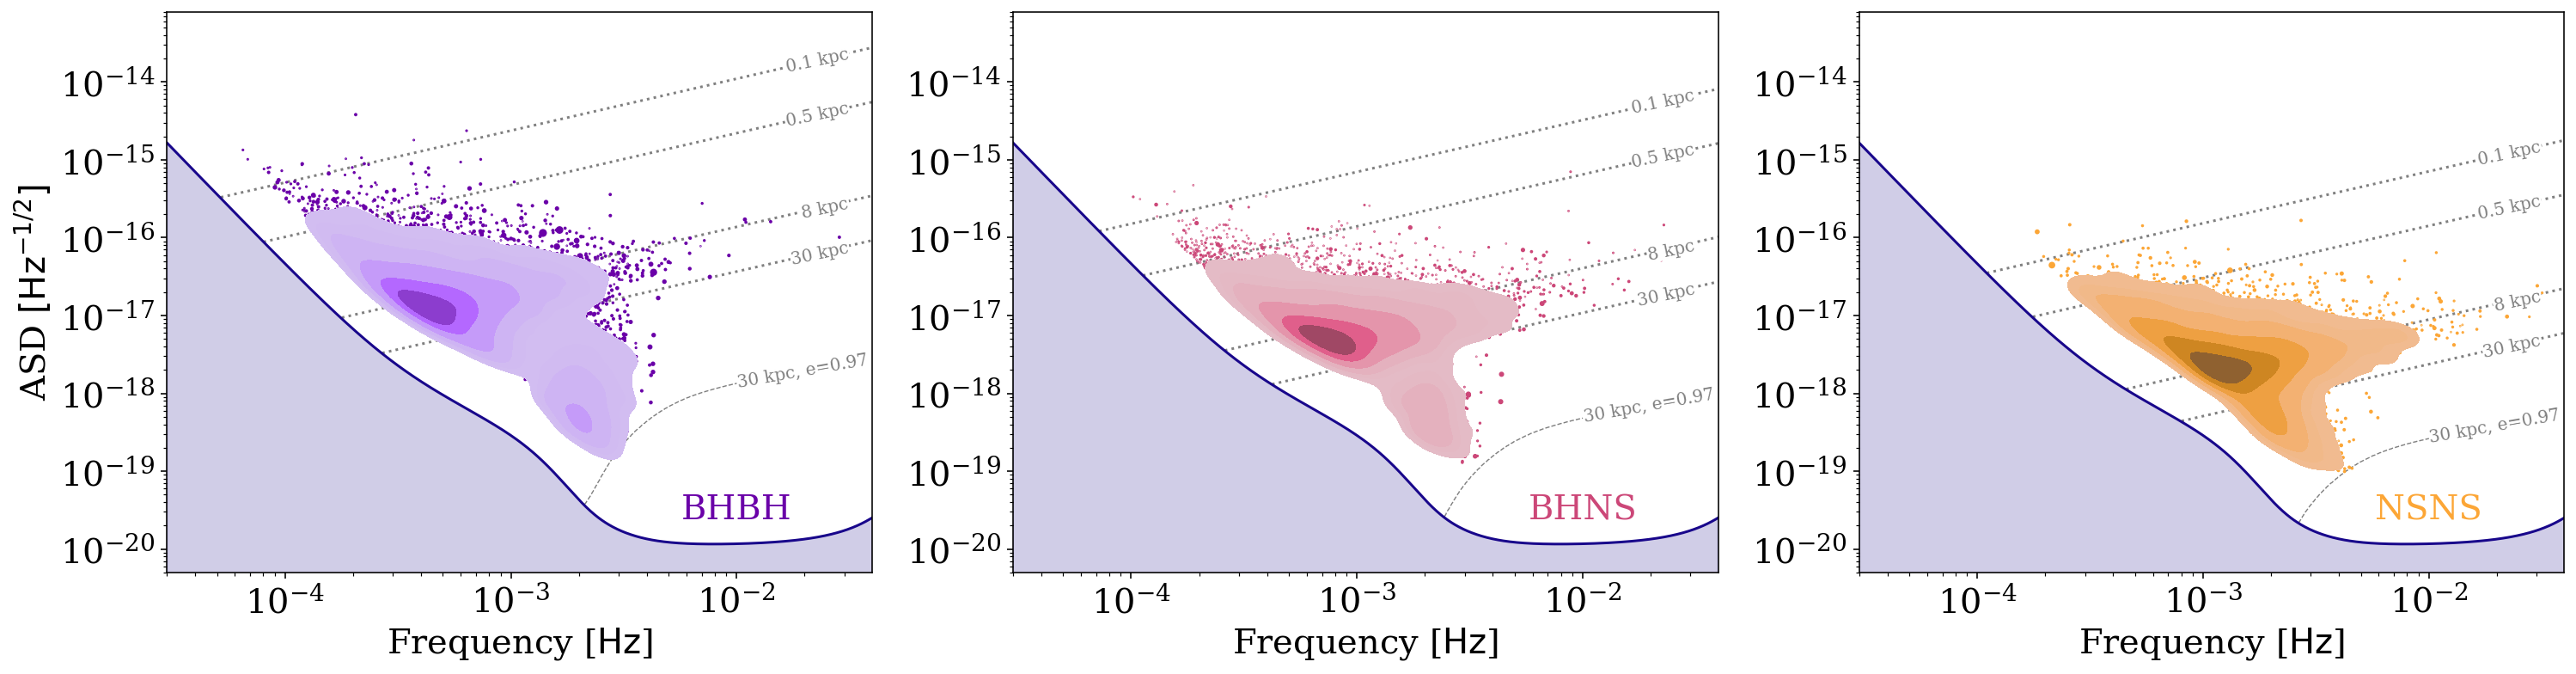

In [110]:
frequency_range = np.logspace(np.log10(3e-5), -1.4, 1000) * u.Hz

fig, axes = plt.subplots(1, 3, figsize=(25, 6))

for i in range(len(dco_types)):
    legwork.visualisation.plot_sensitivity_curve(show=False, frequency_range=frequency_range, fig=fig, ax=axes[i])
    
    line_length = 1000
    lines_f_range = np.logspace(-6.5, -1.4, line_length) * u.Hz
    for dist in [0.1, 0.5, 8, 30]:
        dist_line_signal = np.sqrt(4 * u.yr).to(u.Hz**(-1/2))\
            * legwork.strain.h_0_n(m_c=np.repeat(fid_sources[i].m_c.mean(), line_length),
                                   dist=np.repeat(dist, line_length) * u.kpc, 
                                   f_orb=lines_f_range,
                                   n=2,
                                   ecc=np.zeros(line_length))[:, 0, 0]
        mask = dist_line_signal > np.sqrt(legwork.psd.lisa_psd(lines_f_range * 2))
        axes[i].plot(lines_f_range[mask] * 2, dist_line_signal[mask], color="grey", linestyle="dotted", zorder=0)
        axes[i].annotate("{} kpc".format(dist), xy=(lines_f_range[mask][-20].value, dist_line_signal[mask][-20].value * 0.5), xycoords="data", color="grey", rotation=12, 
                         ha="right", va="center", fontsize=10, bbox=dict(boxstyle="round", ec="white", fc="white", pad=0.0))
        
    for e_dist_line in [0.97]:
        nmax = 220 if e_dist_line == 0.9 else 1000
        e_sources = legwork.source.Stationary(dist=np.repeat(dist, line_length) * u.kpc,
                                          ecc=np.repeat(e_dist_line, line_length),
                                          f_orb=lines_f_range,
                                          m_1=np.repeat(fid_sources[i].m_c.min() * 2**(1/5), line_length),
                                          m_2=np.repeat(fid_sources[i].m_c.min() * 2**(1/5), line_length))
        e_sources.get_snr()
        dominant_freq = lines_f_range * e_sources.max_snr_harmonic
        e_dist_line_signal = e_sources.snr * np.sqrt(legwork.psd.lisa_psd(dominant_freq))
        check = np.argmin(np.diff(dominant_freq))
        mask = e_sources.snr[:check] > 1
        axes[i].plot(dominant_freq[:check][mask], e_dist_line_signal[:check][mask], lw=0.7, zorder=0, color="grey", linestyle="--")
    
    ind = -50
    axes[i].annotate("{} kpc, e={}".format(dist, e_dist_line), xy=(dominant_freq[:check][mask][ind].value, e_dist_line_signal[:check][mask][ind].value), xycoords="data", color="grey",
                     rotation=10, ha="center", va="center", fontsize=10, bbox=dict(boxstyle="round", ec="white", fc="white", pad=0.0))
        
    legwork.visualisation.plot_sources_on_sc_ecc_stat(f_dom=fid_sources[i].f_orb * fid_sources[i].max_snr_harmonic,
                                                      snr=fid_sources[i].snr, fig=fig, ax=axes[i], show=False,
                                                      color=dco_colours[dco_types[i]], s=fid_sources[i].weight * 25)
    
    legwork.visualisation.plot_sources_on_sc_ecc_stat(f_dom=fid_sources[i].f_orb * fid_sources[i].max_snr_harmonic,
                                                      snr=fid_sources[i].snr, fig=fig, ax=axes[i], show=False,
                                                      color=dco_colours[dco_types[i]], weights=fid_sources[i].weight,
                                                      disttype="kde", fill=True, levels=[0.02, 0.05, 0.1, 0.25, 0.5, 0.75, 1.0])

    axes[i].annotate(dco_types[i], xy=(1e-2, 2e-20), xycoords="data", fontsize=fs, color=dco_colours[dco_types[i]], ha="center", va="bottom")
    
    print(dco_types[i], "done")
    
# fig.colorbar(scatter)    

ylims = (5e-21, 8e-14)
    
for ax in axes:
    if ax != axes[0]:
        ax.set_ylabel("")
    ax.tick_params(labelsize=fs)
    ax.xaxis.label.set_fontsize(fs)
    ax.yaxis.label.set_fontsize(fs)
    ax.set_ylim(ylims)
    
# fig.legend(loc='upper center', fontsize=fs, markerscale=20, ncol=3, handletextpad=0, borderaxespad=0.0)

# plt.savefig("../plots/dcos_on_sc.pdf", format="pdf", bbox_inches="tight")
plt.savefig("../../paper/figures/dcos_on_sc.png", dpi=500, bbox_inches="tight")

plt.show()

In [109]:
e_sources.harmonics_required(0.97)

794